# Generate representational similarity matrix

In [1]:
%matplotlib inline

# Handling files
import re
import os
from os.path import join as opj
from glob import glob
import scipy.io as sio

# Analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

Helper functions

In [2]:
subjects = ['sll_opusfmri_%02d' % i for i in range(3, 9)]

# Filter list by subjects
def check_subjects(arr):
    # Sort array
    filtered_arr = arr[:]
    filtered_arr.sort()
    
    # Extract subject id
    extract_id = lambda f: str_extract('sll_opusfmri_[0-9]+', f)
    filtered_arr = [f for f in filtered_arr if extract_id(f) in subjects]
    
    return filtered_arr

# Extract substring
str_extract = lambda pattern, s: re.search(pattern, s).group(0)

# Similarity metric
def cosine_distance(v1, v2):
    dotprod = np.dot(v1, v2)
    mag_v1 = np.sum(np.sqrt(np.power(v1, 2)))
    mag_v2 = np.sum(np.sqrt(np.power(v2, 2)))
    dist = dotprod/(mag_v1*mag_v2)
    
    return dist

# Plot heatmap
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, **kwargs)
    return ax

Experiment directories:

In [3]:
scratch_dir = os.environ['PI_SCRATCH']
project_dir = opj(scratch_dir, 'OPUS')
model_dir = opj(os.environ['PI_HOME'], 'OPUS', '1_behavioral', 'model_RL', 'testing_phase_RL')
behav_dir = opj(project_dir, 'session_data')

# Model output: Self and other weights
sim_dir = opj(project_dir, 'sim_data')
sim_files = glob(opj(sim_dir, '*.mat'))
sim_files = check_subjects(sim_files)

# Model output: Other weights fit to training behavioral
test_files = glob(opj(model_dir, '*.tsv'))
test_files = check_subjects(test_files)

# Probe task behavior
probe_files = glob(opj(behav_dir, '*probe*'))
probe_files = check_subjects(probe_files)

## Representational similarity matrices

### Get preference weights

In [4]:
preferences = {s: {} for s in subjects}
preferences

{'sll_opusfmri_03': {},
 'sll_opusfmri_04': {},
 'sll_opusfmri_05': {},
 'sll_opusfmri_06': {},
 'sll_opusfmri_07': {},
 'sll_opusfmri_08': {}}

Ground truth values (from `sim_files`):

In [5]:
for f in sim_files:
    # Extract subject ID
    tmp_subject = str_extract('sll_opusfmri_[0-9]+', f)

    # Load ground-truth weights from sim_data
    tmp_data = sio.loadmat(f)
    tmp_self = tmp_data['sim_agent']['orig_weights'][0][0]
    tmp_self = tmp_self.flatten()
    tmp_other = tmp_data['sim_agent']['sim_weights'][0][0]
    tmp_other = tmp_other.flatten()

    # Add to preferences dict
    preferences[tmp_subject]['self'] = tmp_self
    preferences[tmp_subject]['other_truth'] = tmp_other

Values estimated from training behavior (from `test_files`):

In [6]:
extract_run = lambda f: str_extract('(?<=test\.)[0-9]', f)
first_test_files = [f for f in test_files if extract_run(f) == '1']

for f in first_test_files:
    tmp_subject = str_extract('sll_opusfmri_[0-9]+', f)
    tmp_data = pd.read_csv(f, sep='\t')
    tmp_data = tmp_data.iloc[0][['W1', 'W2', 'W3']]
    tmp_weights = list(tmp_data)
    preferences[tmp_subject]['other_learned'] = tmp_weights

Check preference weights:

In [7]:
preferences

{'sll_opusfmri_03': {'self': array([ 0.31663004, -0.57546922,  0.13034145]),
  'other_truth': array([1. , 0.5, 0. ]),
  'other_learned': [0.292, 0.209, -0.11699999999999999]},
 'sll_opusfmri_04': {'self': array([ 0.2864242 , -0.2864976 ,  0.14786241]),
  'other_truth': array([-0.5,  0. ,  1. ]),
  'other_learned': [-0.032, -0.013999999999999999, 0.10400000000000001]},
 'sll_opusfmri_05': {'self': array([-0.39073936, -0.08756275, -0.23836087]),
  'other_truth': array([-0.5,  1. ,  0. ]),
  'other_learned': [-0.11, 0.365, -0.046]},
 'sll_opusfmri_06': {'self': array([-0.17448035, -0.11108196,  0.08573629]),
  'other_truth': array([-0.5,  1. ,  0. ]),
  'other_learned': [-0.156, 0.452, 0.006999999999999999]},
 'sll_opusfmri_07': {'self': array([-0.15363103,  0.07055621, -0.06235555]),
  'other_truth': array([0.5, 1. , 0. ]),
  'other_learned': [0.386, 0.431, -0.025]},
 'sll_opusfmri_08': {'self': array([-0.36616163,  0.10740593, -0.20741976]),
  'other_truth': array([0.5, 1. , 0. ]),
  'o

### Plot representational similarity matrices

Movie features:

In [8]:
movies = {'[P, H, R]': [1, 1, 1],
         '[P, H, A]': [1, 1, -1],
         '[P, F, R]': [1, -1, 1],
         '[P, F, A]':[1, -1, -1],
         '[N, H, R]': [-1, 1, 1],
         '[N, H, A]': [-1, 1, -1],
         '[N, F, R]': [-1, -1, 1],
         '[N, F, A]': [-1, -1, -1]}

movie_df = pd.DataFrame([(m1, v1, m2, v2, cosine_distance(v1, v2))
                          for m1, v1 in movies.items() for m2, v2 in movies.items()],
                          columns = ['movie1', 'feat1', 'movie2', 'feat2', 'Features'])

In [46]:
def generate_rsm(subject):
    distance_df = movie_df.copy()

    self_preferences = preferences[subject]['self']
    other_preferences = preferences[subject]['other_learned']

    # Self-relevant similarity
    distance_df['self1'] = [np.multiply(f, self_preferences) for f in distance_df['feat1']]
    distance_df['self2'] = [np.multiply(f, self_preferences) for f in distance_df['feat2']]
    distance_df['Self'] = [cosine_distance(s1, s2) for s1, s2 in zip(distance_df['self1'], distance_df['self2'])]

    # Other-relevant similarity
    distance_df['other1'] = [np.multiply(f, other_preferences) for f in distance_df['feat1']]
    distance_df['other2'] = [np.multiply(f, other_preferences) for f in distance_df['feat2']]
    distance_df['Other'] = [cosine_distance(s1, s2) for s1, s2 in zip(distance_df['other1'], distance_df['other2'])]

    # Representational similarity matrix
    rsm = distance_df.copy()
    rsm = distance_df[['movie1', 'movie2', 'Features', 'Self', 'Other']]
    rsm = pd.melt(rsm, id_vars = ['movie1', 'movie2'],
                  value_vars=['Features', 'Self', 'Other'],
                  var_name='Reference frame',
                  value_name='Distance')

    # Plot heatmap
    fg = sns.FacetGrid(rsm, col='Reference frame', gridspec_kws={"wspace":0})
    fg.map_dataframe(draw_heatmap, 'movie1', 'movie2', 'Distance', cmap='viridis', square = True)

    # Format figure
    #plt.subplots_adjust(top=0.9)
    #fg.fig.suptitle(subject)
    for ax in fg.axes.flat:
        # set aspect of all axis
        ax.set(xlabel='', ylabel='')
        
    return rsm, fg

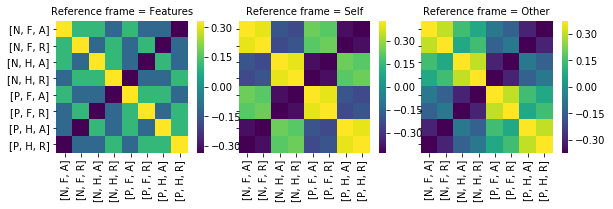

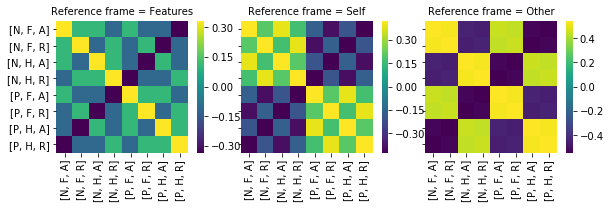

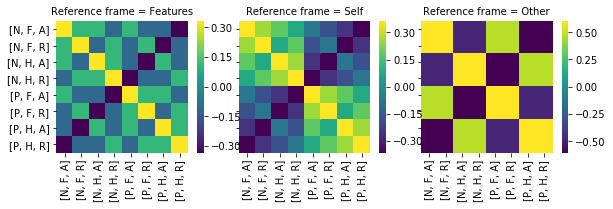

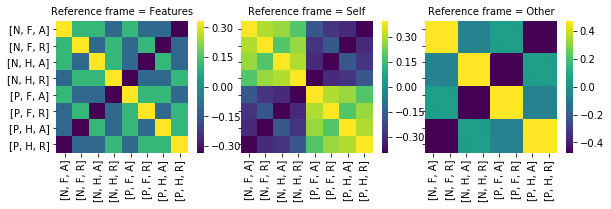

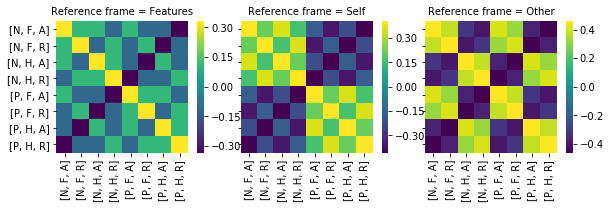

In [13]:
plot_dir = opj(os.getcwd(), 'plots')
valid_subjects = [s for s in subjects if not np.any(np.isnan(preferences[s]['other_learned']))]

for s in valid_subjects:
    # Output file paths
    out_sub = s.replace('sll_opusfmri_', 'sub-')
    out_plot = opj(plot_dir, 'rsa_%s_figure.png' % out_sub)
    out_df = opj(plot_dir, 'rsa_%s_data.tsv' % out_sub)

    # Generate figure and data
    rsa_data, rsa_figure = generate_rsm(s)

    # Save to file
    rsa_data.to_csv(out_df, sep='\t', index=False)
    rsa_figure.savefig(out_plot)